### Imports

In [2]:
import sys
sys.path.append("/Users/kang828/Documents/GitHub/arl-eegmodels")

In [3]:
import tensorflow as tf
import tensorflowjs as tfjs
import pandas as pd
import numpy as np

import seaborn as sns
import datetime

import scipy as sp
import pywt

from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

# from collections.abc import Mapping

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
print("TensorFlow version:", tf.__version__)
sns.set_theme(style="whitegrid")

TensorFlow version: 2.7.0


## Load the original data files

In [4]:
# names = ["Chris", "Jack", "Jacob", "Karuna", "Rena"]
names = ["Jacob", "Karuna", "Rena"]
statuses = ["open", "close"]

original_files = {}

for name in names:
    for status in statuses:
        file_prefix = name + "_" + status + "_"

        for idx in range(1, 3):
            filename = file_prefix + str(idx)

            loaded_file = pd.read_pickle(filename)
            label = 1 if status == "close" else 0

            original_files[filename] = (loaded_file, label)


### Sample from original files to create dataset

In [67]:
def normalize_data(full_matrix):
    assert full_matrix.shape[1] == 4

    out = np.zeros(full_matrix.shape)
    counter = 0

    for col in full_matrix.T:

        ## want to normalize so that the average is 0
        ## and the mean is 1
        zero_mean = col - np.mean(col)
        one_std = zero_mean / np.std(zero_mean)
        out[:, counter] = one_std
        counter += 1
    
    assert out.shape == full_matrix.shape
    return out

def normalize_wavelet(full_matrix):
    assert full_matrix.shape[1] == 4

    # sample_wavelets, _ = pywt.dwt(full_matrix.T[0], 'db6', mode='zero')
    sample_wavelets = np.fft.rfft(full_matrix.T[0], n=1000)
    out = np.zeros((len(sample_wavelets), 4))
    counter = 0

    for col in full_matrix.T:
        # wavelets, _ = pywt.dwt(col, 'db6', mode="zero")
        wavelets = np.fft.rfft(col, n=1000)
        out[:, counter] = wavelets
        counter += 1
        # assert len(wavelets) == 6, "Constant found through testing; may be incorrect"

    return out

In [68]:
NUMBER_OF_SAMPLES_FROM_INDIV = 80
WIDTH = 1000

samples = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files), WIDTH, 4))
# wavelets = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files), 505, 4))
wavelets = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files), 501, 4))
labels = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files)))

counter = 0

for filename in original_files.keys():
    raw_data, label = original_files[filename]
    
    eeg_data = raw_data[[1, 2, 3, 4]].to_numpy()
    
    for _ in range(NUMBER_OF_SAMPLES_FROM_INDIV):
        start_time = np.random.randint(0, len(eeg_data) / 2 - WIDTH)

        sampled_data = eeg_data[start_time:start_time + WIDTH]

        sampled_data = normalize_data(sampled_data)
        wavelet_data = normalize_wavelet(sampled_data)

        assert sampled_data.shape == (WIDTH, 4)
        
        samples[counter] = sampled_data
        wavelets[counter] = wavelet_data
        labels[counter] = label
        
        counter += 1



/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/78679

In [69]:
## shuffle the dataset
permutation = np.random.permutation(len(samples))
samples = samples[permutation]
wavelets = wavelets[permutation]
labels = labels[permutation]

### Validation data creation

In [70]:
names = ["karuna", "rena"]
statuses = ["open", "closed"]

old_files = {}

for name in names:
    for status in statuses:
        file_prefix = "./Archive/" + name + "_" + status + "_"

        for idx in range(1, 3):
            filename = file_prefix + str(idx)

            loaded_file = pd.read_pickle(filename)
            label = 1 if status == "closed" else 0

            old_files[filename] = (loaded_file, label)

In [71]:
## also sample from these files
NUMBER_OF_VALIDATION_SAMPLES = 10

val_samples = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files), WIDTH, 4))
# val_wavelets = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files), 505, 4))
val_wavelets = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files), 501, 4))
val_labels = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files)))

counter = 0

for filename in old_files.keys():
    raw_data, label = old_files[filename]
    
    eeg_data = raw_data[[1, 2, 3, 4]].to_numpy()
    
    for _ in range(NUMBER_OF_VALIDATION_SAMPLES):
        start_time = np.random.randint(0, len(eeg_data) - WIDTH)

        sampled_data = eeg_data[start_time:start_time + WIDTH]

        sampled_data = normalize_data(sampled_data)
        wavelet_data = normalize_wavelet(sampled_data)
        assert sampled_data.shape == (WIDTH, 4)
        
        samples[counter] = sampled_data
        val_wavelets[counter] = wavelet_data
        val_labels[counter] = label
        
        counter += 1


/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/78679

In [72]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(120, 250, input_shape=(501, 4), activation='sigmoid'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(80, 30, activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(60, 10),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(40),
    tf.keras.layers.Dense(2)
])

model.summary()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 252, 120)          120120    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 126, 120)         0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 97, 80)            288080    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 48, 80)           0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 39, 60)            48060     
                                                                 
 flatten_8 (Flatten)         (None, 2340)             

### Train

In [73]:
model.fit(x=wavelets, y=labels, batch_size=30, epochs=6, 
          validation_data=(val_wavelets, val_labels))


Epoch 1/6
32/32 [==============================] - 3s 70ms/step - loss: 5.4365 - accuracy: 0.4833 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/6
32/32 [==============================] - 2s 67ms/step - loss: 0.6942 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/6
32/32 [==============================] - 2s 68ms/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/6
32/32 [==============================] - 2s 65ms/step - loss: 0.6938 - accuracy: 0.4979 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/6
32/32 [==============================] - 2s 69ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/6
32/32 [==============================] - 2s 65ms/step - loss: 0.6940 - accuracy: 0.4875 - val_loss: 0.6938 - val_accuracy: 0.5000


In [82]:
def produce_transfer_data(filename, storage_array, NUM_SAMPLES=20):
    data_file, label = storage_array[filename]
    eeg_data = data_file[[1, 2, 3, 4]].to_numpy()

    # out = np.zeros((NUM_SAMPLES, WIDTH, 4))
    out = np.zeros((NUM_SAMPLES, 501, 4))


    for idx in range(NUM_SAMPLES):
        start_time = np.random.randint(0, len(data_file) - WIDTH)
        out[idx] = normalize_wavelet(normalize_data(eeg_data[start_time:start_time + WIDTH]))
    
    return out, np.ones(len(out)) * label

trans_data_1, trans_label_1 = produce_transfer_data("Rena_close_1", original_files)
trans_data_2, trans_label_2 = produce_transfer_data("Rena_open_1", original_files)

trans_data = np.vstack((trans_data_1, trans_data_2))
trans_label = np.append(trans_label_1, trans_label_2)

permutation = np.random.permutation(len(trans_data))
trans_data = trans_data[permutation]
trans_label = trans_label[permutation]

/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets


In [83]:
val_data_1, val_label_1 = produce_transfer_data("./Archive/rena_closed_1", old_files)
val_data_2, val_label_2 = produce_transfer_data("./Archive/rena_open_1", old_files)

val_data = np.vstack((val_data_1, val_data_2))
val_label = np.append(val_label_1, val_label_2)

permutation = np.random.permutation(len(val_data))
val_data = val_data[permutation]
val_label = val_label[permutation]

/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets
/var/folders/pv/_wx2n4fs1q36km9194nv47wmvdblm_/T/ipykernel_43416/786796220.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, counter] = wavelets


In [84]:
trans_label

array([1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1.])

In [85]:
model.fit(x=trans_data, y=trans_label, validation_data=(val_data, val_label), epochs=3)

Epoch 1/3
2/2 [==============================] - 1s 111ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 84ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 85ms/step - loss: 0.6937 - accuracy: 0.4500 - val_loss: 0.6933 - val_accuracy: 0.5000


In [86]:
model.predict(wavelets)

array([[ 0.02106974, -0.01449971],
       [ 0.02106974, -0.01449971],
       [ 0.02106974, -0.01449971],
       ...,
       [ 0.02106974, -0.01449971],
       [ 0.02106975, -0.01449971],
       [ 0.02106975, -0.01449971]], dtype=float32)

## Data Exploration


20.891867750110563


<AxesSubplot:>

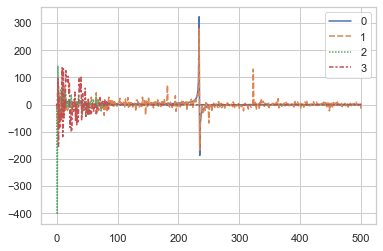

In [79]:
test_data = wavelets[4]
print(np.std(test_data[:, 2]))
sns.lineplot(data=test_data)

<AxesSubplot:>

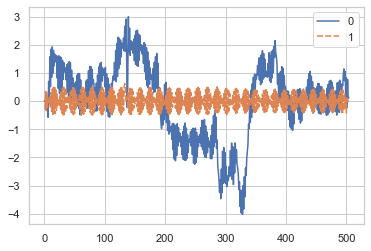

In [41]:
# print(len(pywt.dwt(sampled_data[2][:, 1], 'db6', mode="zero")[0]))
sns.lineplot(data=pywt.dwt(samples[2][:, 0], 'db6', mode="zero"))

/opt/anaconda3/envs/neurahack/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot:>

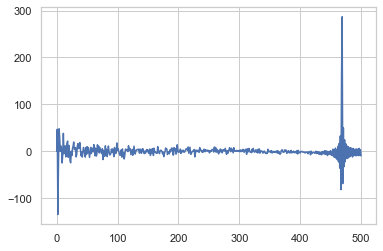

In [63]:
transformed = np.fft.rfft(test_data[:, 0], n=1000)
# transformed_wvlt_1 = pywt.wavedec(test_data[:, 1], 'db6', mode="zero")
# transformed_wvlt_2 = pywt.wavedec(test_data[:, 3], 'db6', mode="zero")
# sns.lineplot(data=transformed)/
sns.lineplot(data=transformed)

<AxesSubplot:>

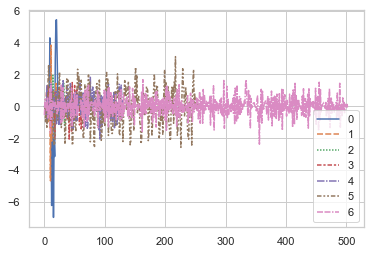

In [20]:
sns.lineplot(data=transformed_wvlt_1)



/opt/anaconda3/envs/neurahack/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot:>

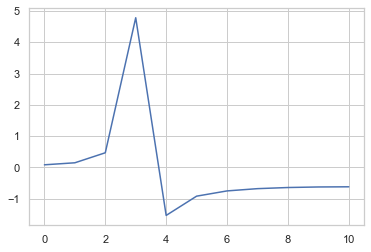

In [21]:
sns.lineplot(data=np.fft.rfft(np.sin(np.arange(512)), n=20))